## Imports

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string     
from bs4 import BeautifulSoup
from collections import defaultdict

import nltk
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy

from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec, KeyedVectors 

#nltk.download('punkt')
#nltk.download('stopwords')

stop_words = stopwords.words('english')
sp = spacy.load('en_core_web_sm')

## All Data information

In [16]:
# read all datasets
df_all = pd.read_csv('./data/APC_lab_raw.csv', names=["number", "issuekey", "title", "description", "timestamp"])

In [17]:
df_all.head()

,number,issuekey,title,description,timestamp
0,13338643,ZOOKEEPER,addWatch api should check the null watch,{code:java}\r\npublic void addWatch(String bas...,6000
1,13338634,ZOOKEEPER,QuorumCnxManager Listener port bind retry does...,We run Zookeeper in a container environment wh...,9000
2,13336630,ZOOKEEPER,C client test suite hangs forever 'sss' is con...,While testing a full build on the master branc...,3600
3,13336395,ZOOKEEPER,Flaky test MultipleAddressTest::testGetValidAd...,Problem:\r\n\r\nTest MultipleAddressTest::test...,3000
4,13336268,ZOOKEEPER,Fix Jenkinsfiles with new tool names,NaN,2400


In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43548 entries, 0 to 43547
Data columns (total 5 columns):
number         43548 non-null int64
issuekey       43548 non-null object
title          43548 non-null object
description    38179 non-null object
timetamp       43548 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


In [18]:
# converting storypoint column type int->str
df_all['timestamp'] = df_all['timestamp'].astype(str)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43548 entries, 0 to 43547
Data columns (total 5 columns):
number         43548 non-null int64
issuekey       43548 non-null object
title          43548 non-null object
description    38179 non-null object
timestamp      43548 non-null object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [19]:
# count all missing values
for col in df_all.columns:
    print(col, df_all[col].isnull().sum())

number 0
issuekey 0
title 0
description 5369
timestamp 0


In [20]:
# show all missing value rows
df_all[df_all.isna().any(axis=1)]

,number,issuekey,title,description,timestamp
4,13336268,ZOOKEEPER,Fix Jenkinsfiles with new tool names,NaN,2400
28,13325855,ZOOKEEPER,Update Netty to 4.1.50Final on 3.5 branch,NaN,1800
29,13325849,ZOOKEEPER,Netty and JLine Licenses are inconsistent with...,NaN,2400
76,13299442,ZOOKEEPER,RAT check fails on fatjar module,NaN,13200
93,13294313,ZOOKEEPER,Update zk-merge-pr script to Python3,NaN,9000
106,13289780,ZOOKEEPER,Move the download page to downloads.apache.org,NaN,2400
107,13289779,ZOOKEEPER,Update copyright notices from 2019 to 2020,NaN,2400
126,13282527,ZOOKEEPER,[trivial bug] fix compile error in PurgeTxnTes...,NaN,600
138,13278739,ZOOKEEPER,Use StandardCharsets UTF-8 in Jute toString,NaN,4800
139,13278736,ZOOKEEPER,Jute Use JDK hashCode Methods for Native Types,NaN,4800


In [21]:
# storypoint frequencies
# should be Fibonacci-like format: 0, 0.5????, 1, 2, 3, 5, 8, 13, 20, 40, 100. 
# but here we have 21, 4, 9, 34,... anomaly)))
df_all['timestamp'].value_counts()

1200       11918
1800        4783
2400        3767
600         2675
3600        2407
3000        2320
4200        1490
4800        1415
5400        1190
6000         964
7200         882
6600         809
7800         572
9000         551
8400         518
9600         489
10800        439
10200        381
11400        337
12000        299
12600        297
14400        295
13200        255
13800        220
18000        185
16200        176
15600        174
15000        170
16800        164
17400        140
           ...  
63180          1
5580           1
229800         1
12420          1
14460          1
284400         1
581400         1
25620          1
97800          1
30             1
20100          1
260400         1
118200         1
80100          1
216000         1
217800         1
780600         1
18960          1
5184000        1
82200          1
6420           1
26640          1
33300          1
1140           1
193200         1
11940          1
213600         1
124800        

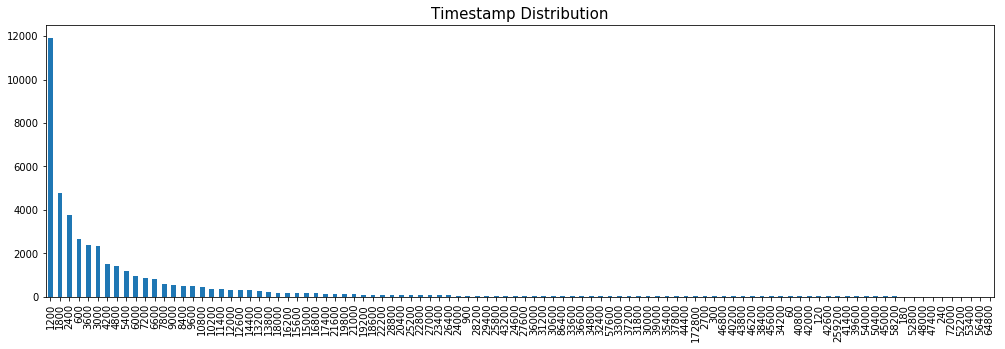

In [24]:
plt.figure(figsize=(17,5))
df_all['timestamp'].value_counts()[:100].plot(kind='bar')
plt.title('Timestamp Distribution', fontsize=15);

## Preprocessing

In [25]:
labels = df_all["timestamp"].values
X = df_all.drop(["issuekey", "timestamp"], axis=1)


# issuekey include???
X.head()

,number,title,description
0,13338643,addWatch api should check the null watch,{code:java}\r\npublic void addWatch(String bas...
1,13338634,QuorumCnxManager Listener port bind retry does...,We run Zookeeper in a container environment wh...
2,13336630,C client test suite hangs forever 'sss' is con...,While testing a full build on the master branc...
3,13336395,Flaky test MultipleAddressTest::testGetValidAd...,Problem:\r\n\r\nTest MultipleAddressTest::test...
4,13336268,Fix Jenkinsfiles with new tool names,NaN


In [26]:
# replace missing values with empty strings
X = X.fillna('')

In [27]:
# concat title to description by space/dot?? 
# may be model will give to title more weights than to the description, so we should't concat them???
X["title_description"] = X["title"] + " " +  X["description"]
X["title_description"][2]

"C client test suite hangs forever 'sss' is configured in /etc/nsswitch.conf While testing a full build on the master branch (3.7.0-SNAPSHOT), I observed that the C client tests hang indefinitely when reaching the zktest-mt's Zookeeper_close test suite (nothing is printed from that suite, but Zookeeper_init finishes and then nothing is printed)\\r\\n\\r\\nAttaching gdb as a debugger to the zktest-mt process, with the help of [~ztzg]\\xc2\\xa0and [~symat] I saw that it was stuck in the sss because of the test mocking sockets, and sss requiring a non-mocked socket to call getpwuid_r and getlogin functions in zookeeper-client/zookeeper-client-c/src/zookeeper.c\\r\\n\\r\\nDisabling the lines in zookeeper.c that called those functions, which seemed to be used for logging information only, the tests were able to proceed and complete in under 9 minutes (full-build, without running any surefire/junit tests)."

In [28]:
text = X["title_description"].to_numpy()
print("text length is", len(text))
text

text length is 43548


array(['addWatch api should check the null watch {code:java}\\r\\npublic void addWatch(String basePath, Watcher watcher, AddWatchMode mode)\\r\\n        throws KeeperException, InterruptedException {\\r\\n    PathUtils.validatePath(basePath);\\r\\n    String serverPath = prependChroot(basePath);\\r\\n\\r\\n    RequestHeader h = new RequestHeader();\\r\\n    h.setType(ZooDefs.OpCode.addWatch);\\r\\n    AddWatchRequest request = new AddWatchRequest(serverPath, mode.getMode());\\r\\n    ReplyHeader r = cnxn.submitRequest(h, request, new ErrorResponse(),\\r\\n    \\r\\n{code}\\r\\nwe need to\\xc2\\xa0_*validateWatcher(watcher)*_\\xc2\\xa0to ** avoid the case:\\r\\n{code:java}\\r\\nzk.addWatch("/a/b", null, PERSISTENT_RECURSIVE);\\r\\n{code}',
       'QuorumCnxManager Listener port bind retry does not retry DNS lookup We run Zookeeper in a container environment where DNS is not stable. As recommended by the documentation, we set _electionPortBindRetry_ to 0 (keeps retrying forever).\\r\\n\\

In [29]:
def preprocess_txt(doc):
    #lowercase
    doc = doc.lower() 
    #remove "{html}" strings
    doc = re.sub('\{html\}', '', doc)
    #remove html tags
    doc = BeautifulSoup(doc, 'html.parser').get_text()
    #remove all paths/urls/--keys
    pattern = re.compile(r'[/\-+\\+]')
    doc_split = [token for token in WhitespaceTokenizer().tokenize(doc) if not pattern.findall(token)]
    doc = " ".join(doc_split)

    #tokenize and remove stop words and punctuation symbols and spaces using spaCy
    #use lemmas
    doc_spacy = sp(doc)
    doc_tokenized_spacy = [token.lemma_ for token in doc_spacy
        if not token.is_stop and not token.is_punct and not token.is_space]

    #preprocessing additionaly with nltk give much better results
    doc_nltk = " ".join(doc_tokenized_spacy)
    #tokenize and remove stop words and punctuation symbols using nltk 
    #remove numerics
    doc_tokenized_spacy_nltk = [token for token in nltk.word_tokenize(doc_nltk)
        if token.isalpha()]
    
    return doc_tokenized_spacy_nltk                                         

In [30]:
# creating the corpus
def create_corpus(text_arr):
    corpus = []

    for doc in text_arr:
        prep_doc = preprocess_txt(doc)                            
        corpus.append(prep_doc)
        
    return corpus    

In [31]:
corpus = create_corpus(text)
len(corpus)

43548

In [32]:
def create_vocab(corpus):
    vocab = set(token for doc in corpus for token in doc)
    
    return vocab

In [33]:
vocab = create_vocab(corpus)
len(vocab)

46409

In [90]:
# an example of preprocessing before/after

print("---------------Original text------------------\n")
doc = text[1]
print(doc)
doc = doc.lower()
doc = doc.replace('\{html\}', '')
doc = BeautifulSoup(doc, 'html.parser').get_text()

print("\n---------------After removing paths/urls/--keys------------------\n")
pattern = re.compile(r'[/\-+\\+]')
doc_split = [token for token in WhitespaceTokenizer().tokenize(doc) if not pattern.findall(token)]
doc = " ".join(doc_split)

print(doc_split)

#preprocessing with only spaCy
print("\n---------------spaCy prep + lemma------------------\n")
doc_spacy = sp(doc)
doc_tokenized_spacy = [token.lemma_ for token in doc_spacy
    if not token.is_stop and not token.is_punct and not token.is_space]
print(doc_tokenized_spacy)

#preprocessing with spaCy + nltk
# print("\n---------------spaCy + lemma + nltk prep + is_not_numeric-----------------\n")
# doc_nltk = " ".join(doc_tokenized_spacy)
# doc_tokenized_spacy_nltk = [token for token in nltk.word_tokenize(doc_nltk)
#     if token not in stop_words and token not in string.punctuation and not token.isnumeric()]
# print(doc_tokenized_spacy_nltk)

print("\n---------------spaCy + lemma + nltk prep + isalpha-----------------\n")
doc_nltk = " ".join(doc_tokenized_spacy)
doc_tokenized_spacy_nltk = [token for token in nltk.word_tokenize(doc_nltk)
    if token not in stop_words and token not in string.punctuation and token.isalpha()]
print(doc_tokenized_spacy_nltk)

---------------Original text------------------

QuorumCnxManager Listener port bind retry does not retry DNS lookup We run Zookeeper in a container environment where DNS is not stable. As recommended by the documentation, we set _electionPortBindRetry_ to 0 (keeps retrying forever).\r\n\r\nOn some instances, we get the following exception in an infinite loop, even though the address already became resolve-able:\r\n\r\n\xc2\xa0\r\n{noformat}\r\nzk-2_1  | 2020-11-03 10:57:08,407 [myid:3] - ERROR [ListenerHandler-zk-2.test:3888:QuorumCnxManager$Listener$ListenerHandler@1093] - Exception while listening\r\nzk-2_1  | java.net.SocketException: Unresolved address\r\nzk-2_1  | \tat java.base/java.net.ServerSocket.bind(Unknown Source)\r\nzk-2_1  | \tat java.base/java.net.ServerSocket.bind(Unknown Source)\r\nzk-2_1  | \tat org.apache.zookeeper.server.quorum.QuorumCnxManager$Listener$ListenerHandler.createNewServerSocket(QuorumCnxManager.java:1140)\r\nzk-2_1  | \tat org.apache.zookeeper.server.qu

In [37]:
def show_most_freq_n(corp, n):
    allwords = [token for doc in corp for token in doc]
    
    # word freqs    
    mostcommon_small = nltk.FreqDist(allwords).most_common(n)
    print(mostcommon_small)
    x, y = zip(*mostcommon_small)
    plt.figure(figsize=(50,30))
    plt.margins(0.02)
    plt.bar(x, y)
    plt.xlabel('Words', fontsize=50)
    plt.ylabel('Frequency of Words', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xticks(rotation=60, fontsize=40)
    plt.title('Frequency of {} Most Common Words'.format(n), fontsize=60)
    plt.show()    

[('file', 13113), ('add', 11491), ('test', 10850), ('error', 9984), ('fail', 9821), ('use', 8920), ('new', 7638), ('create', 7593), ('try', 6923), ('support', 6715), ('table', 6620), ('run', 6345), ('code', 6068), ('type', 6006), ('class', 5977), ('line', 5905), ('version', 5866), ('value', 5827), ('need', 5685), ('set', 5424), ('info', 5394), ('return', 5173), ('time', 5170), ('build', 5088), ('null', 5084), ('exec', 5077), ('method', 5066), ('fix', 5016), ('user', 4944), ('change', 4905), ('string', 4610), ('update', 4606), ('remove', 4518), ('datum', 4435), ('issue', 4326), ('case', 4185), ('server', 4174), ('default', 4133), ('find', 4042), ('start', 4016), ('exception', 4013), ('work', 3997), ('client', 3986), ('log', 3856), ('check', 3762), ('cause', 3756), ('message', 3739), ('result', 3612), ('follow', 3600), ('query', 3565)]


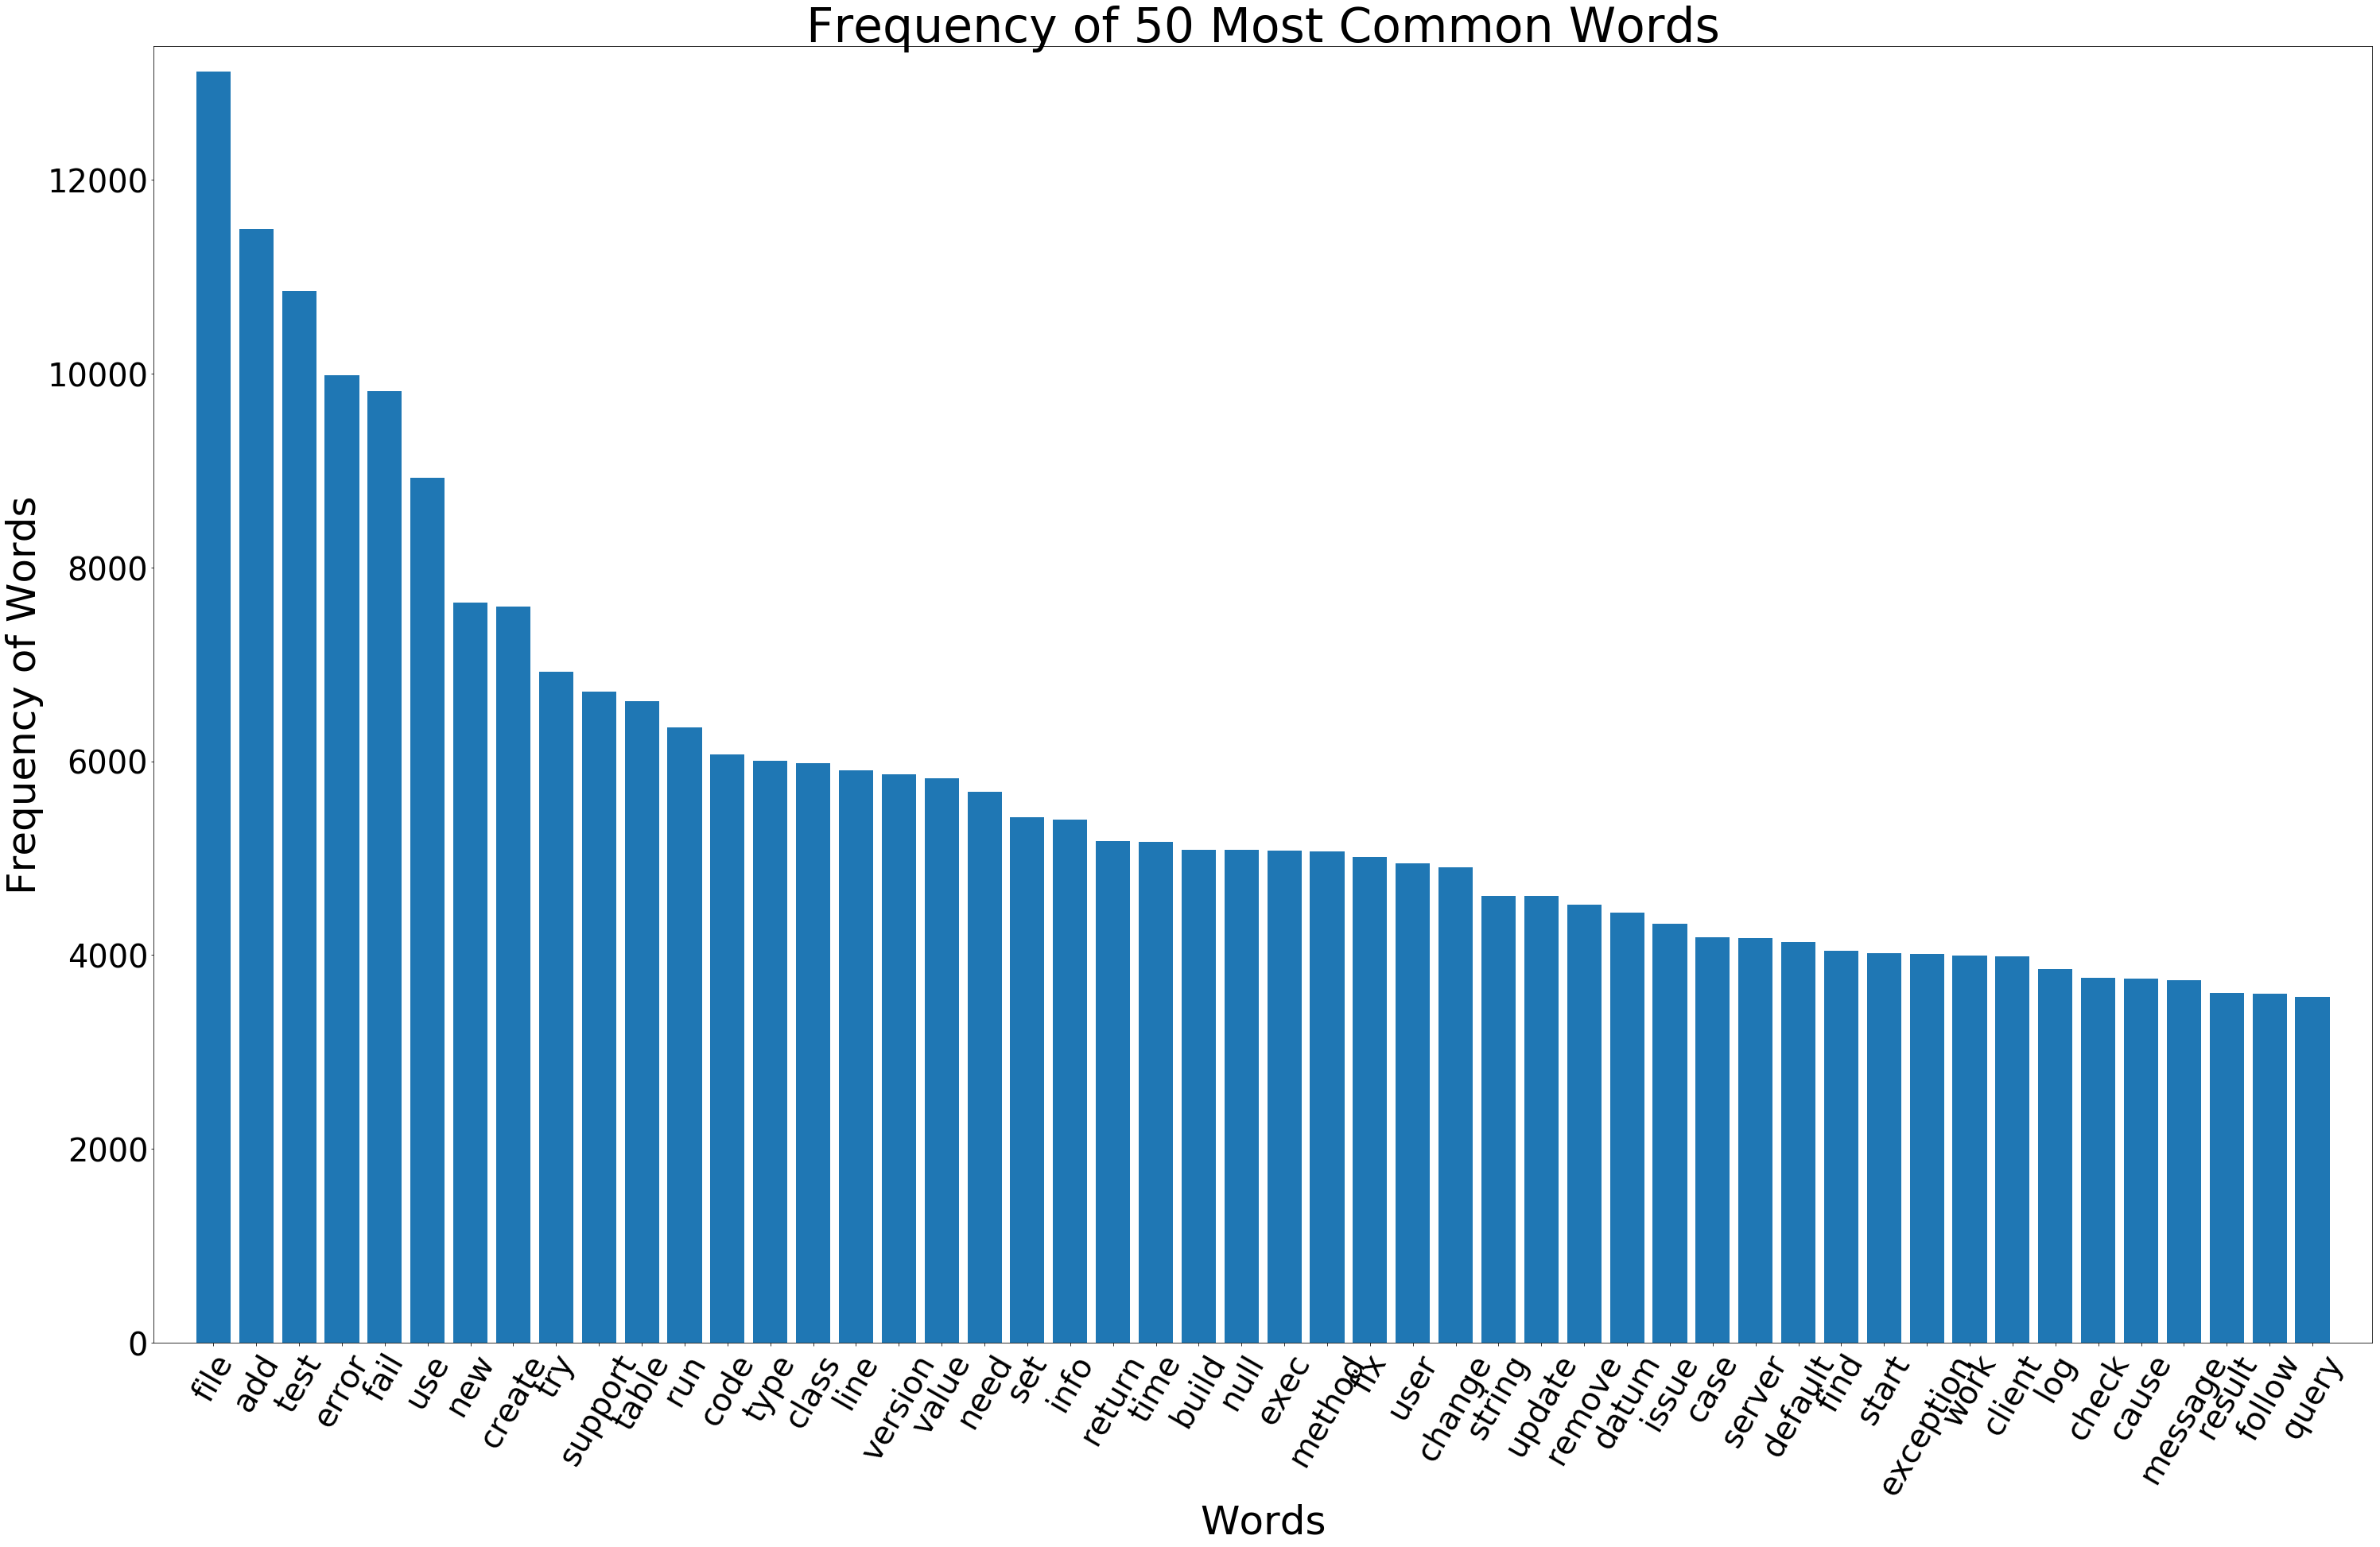

In [38]:
show_most_freq_n(corpus, 50)

In [79]:
# load pre-trained w2v model
model = KeyedVectors.load_word2vec_format("./data/GoogleNews-vectors-negative300.bin",  binary = True)

In [80]:
# the tokens count that are in our corpus but misses from the pre-traned model
new_elements = vocab - set(model.vocab.keys())
print("new words count in vocabulary", len(new_elements))
print("in common words count in vocabulary and pre-trained model", len(vocab) - len(new_elements))

new words count in vocabulary 34452
in common words count in vocabulary and pre-trained model 11957


In [81]:
# get most common words list from our vocabulary
corpus_as_words = [token for doc in corpus for token in doc]
most_common_items = nltk.FreqDist(corpus_as_words).most_common(30)
most_common_items[:5]

[('file', 13113),
 ('add', 11491),
 ('test', 10850),
 ('error', 9984),
 ('fail', 9821)]

In [82]:
# get most common words key list from our vocabulary
most_common = [k for k,i in most_common_items]
print(most_common)

['file', 'add', 'test', 'error', 'fail', 'use', 'new', 'create', 'try', 'support', 'table', 'run', 'code', 'type', 'class', 'line', 'version', 'value', 'need', 'set', 'info', 'return', 'time', 'build', 'null', 'exec', 'method', 'fix', 'user', 'change']


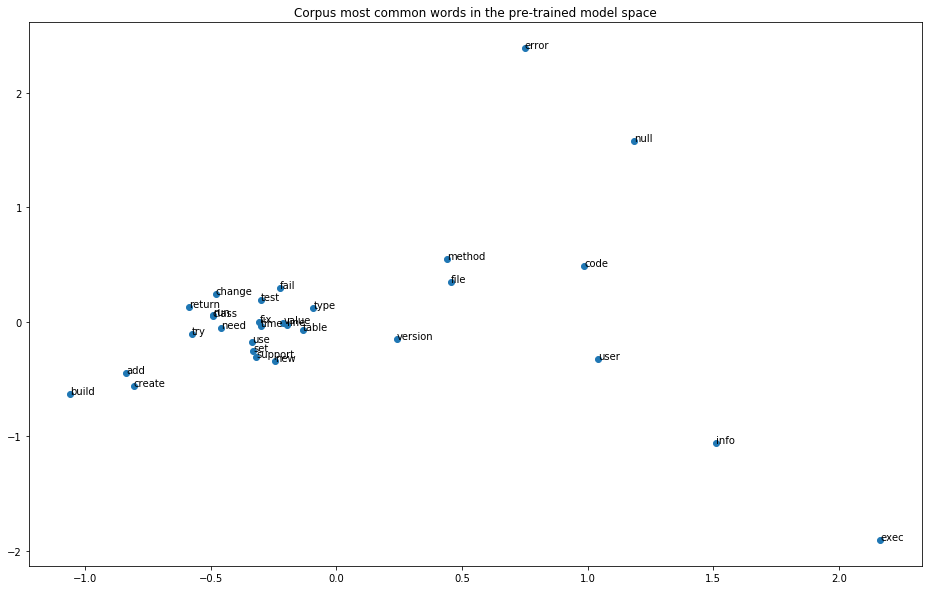

In [83]:
X = [model[key] for key in most_common]

# fit a 2d PCA model to the vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(16,10))    
plt.title('Corpus most common words in the pre-trained model space')
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(most_common):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show();

In [119]:
#init word2vec, not pre-trained
model_2 = Word2Vec(size=300, min_count=1)
model_2.corpus_count, model_2.wv.vocab

(0, {})

In [120]:
#build new vocabulary
model_2.build_vocab(corpus)

In [121]:
model_2.intersect_word2vec_format("./data/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


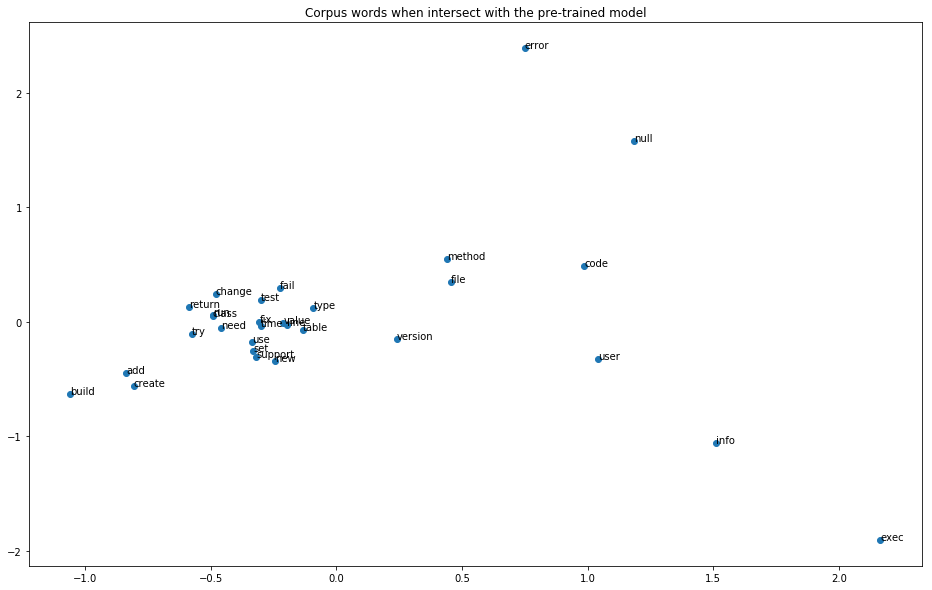

In [122]:
X_3 = [model_2[key] for key in most_common]

# fit a 2d PCA model to the vectors
pca_3 = PCA(n_components=2)
result_3 = pca_3.fit_transform(X_3)
# create a scatter plot of the projection
plt.figure(figsize=(16,10))    
plt.title('Corpus words when intersect with the pre-trained model')
plt.scatter(result_3[:, 0], result_3[:, 1])
for i, word in enumerate(most_common):
    plt.annotate(word, xy=(result_3[i, 0], result_3[i, 1]))

plt.show();

In [123]:
model_2.train(corpus, total_examples=model_2.corpus_count, epochs=1000)

(1244276702, 1335217000)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


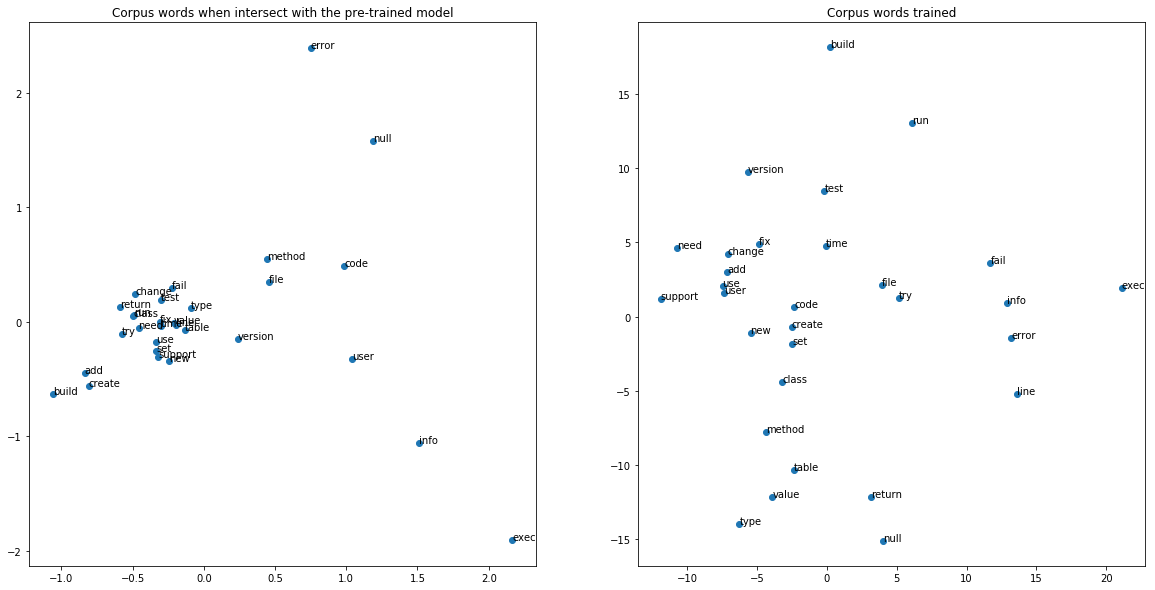

In [124]:
# create a scatter plot of the projection
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# use reults after pre-training    
ax1.set_title('Corpus words when intersect with the pre-trained model')
ax1.scatter(result_3[:, 0], result_3[:, 1])
for i, word in enumerate(most_common):
    ax1.annotate(word, xy=(result_3[i, 0], result_3[i, 1]))

X_4 = [model_2[key] for key in most_common]

# fit a 2d PCA model to the vectors
pca_4 = PCA(n_components=2)
result_4 = pca_4.fit_transform(X_4)
# create a scatter plot of the projection  
ax2.set_title('Corpus words trained')
ax2.scatter(result_4[:, 0], result_4[:, 1])
for i, word in enumerate(most_common):
    ax2.annotate(word, xy=(result_4[i, 0], result_4[i, 1]))